In [130]:


from pathlib import Path
from os.path import expanduser
from os import path
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os


# In[2]:


root_folder = os.path.dirname(os.getcwd())
path_to_ground_truth_data = path.join(root_folder,'data/synthesized/gt_46.npy');
path_to_recording= path.join(root_folder,'data/synthesized/data_46.npy');

sys.path.append(root_folder)
from custom_resnet import CustomResnet as cnn


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

waveform_length = 72;
step_size = int(np.round(waveform_length * 0.1))
batch_size = 15000;


# In[3]:


# loads spike detection model
num_classes_detect = 2;
path_to_model_detect = path.join(root_folder, 'models/detect/resnet18_num_classes_2_epoch_22.pt')
model_detect = cnn.resnet18(num_classes=num_classes_detect);
checkpoint = torch.load(path_to_model_detect)
model_detect.load_state_dict(checkpoint['model_state_dict'])
model_detect.to(device);


# In[4]:


# loads re id model
num_classes_re_id = 499;
path_to_model_re_id = path.join(root_folder, 'models/re_id/resnet18_num_classes_499_epoch_74.pt')
model_re_id = cnn.ft_net(class_num = num_classes_re_id);
checkpoint = torch.load(path_to_model_re_id)
model_re_id.load_state_dict(checkpoint['model_state_dict'])
model_re_id.to(device);

max_amplitude_index_per_rec = [];
# In[5]:
for d in range(1, 96):
    path_to_ground_truth_data = path.join(root_folder,'data/synthesized/gt_'+ str(d)+'.npy');
    path_to_recording= path.join(root_folder,'data/synthesized/data_' + str(d) +'.npy');


    # transforms data for inference
    transform = transforms.Compose([cnn.FilterSignalUsingButtersWorth('high', 24000, np.array([100], dtype=int), 1), cnn.OptimizedZScoreNormalizaton()])
    recording = cnn.Recording(path_to_recording, transform = transform);
    recording_padded = cnn.AddPaddingToRecording(recording, step_size, waveform_length)
    # gets waveform data for each window
    waveform_indices = cnn.GetWaveformIndices(recording_padded, step_size, waveform_length)
    transform = transforms.Compose([cnn.ExtractWaveforms(waveform_indices, waveform_length)])
    waveforms = transform(recording_padded.data);
    normalized_waveforms = waveforms;


    # In[6]:


    ### spike detection pipeline
    # loads data for inference
    dataset_to_infer_detect = cnn.InferenceDataset(normalized_waveforms.to(device));
    data_loader_detect = torch.utils.data.DataLoader(dataset_to_infer_detect, batch_size=batch_size, shuffle=False, num_workers=0);

    #inference for detection 
    result_detect = cnn.Inference(model_detect, data_loader_detect, num_classes_detect)
    treshold = 0.9;
    predictions = cnn.PredictionByTreshold(result_detect, treshold)
    max_amplitude_index = cnn.GetNonOverlappingSpikesMaxAmplitude(recording_padded, predictions, waveform_length, waveforms, waveform_indices)


    # In[7]:


    del dataset_to_infer_detect, data_loader_detect
    torch.cuda.empty_cache()



    # In[8]:

    non_out_of_bound_index = np.where((max_amplitude_index - waveform_length // 2 >= 0) & (max_amplitude_index + waveform_length // 2 < recording.__len__()));
    max_amplitude_index = max_amplitude_index[non_out_of_bound_index];

    max_amplitude_index_per_rec.append(max_amplitude_index);

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch


done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104

done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  ba

done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done

done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
do

done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch


done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  bat

done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120 

done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28

done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  bat

done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done

done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batc

done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  bat

done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batc

done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done

done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  bat

done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [

done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47 

done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  bat

done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done: 

done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch

done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103 

done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  ba

done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:

done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
don

done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch

done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batc

done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  ba

done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done: 

In [152]:
max_amplitude_index_per_rec
np.save("detected_data.npy", max_amplitude_index_per_rec)


In [153]:
detected_indices = np.load('detected_data.npy')

In [241]:
detected_indices = detected_indices[45:95]

SyntaxError: invalid syntax (<ipython-input-242-e0c1769b9761>, line 1)

In [364]:
features_per_rec = [];
for d in range(46, 96):
    path_to_ground_truth_data = path.join(root_folder,'data/synthesized/gt_'+ str(d)+'.npy');
    path_to_recording= path.join(root_folder,'data/synthesized/data_' + str(d) +'.npy');
    transform = transforms.Compose([cnn.FilterSignalUsingButtersWorth('high', 24000, np.array([100], dtype=int), 1), cnn.OptimizedZScoreNormalizaton()])
    recording = cnn.Recording(path_to_recording, transform = transform);
    max_amplitude_index = torch.unsqueeze(torch.tensor(detected_indices[d - 46]), 0);
    transform = transforms.Compose([cnn.ExtractWaveforms(max_amplitude_index, waveform_length)])
    waveforms_re_id = transform(recording.data);
    #vertical flip
    waveforms_re_id_flipped = waveforms_re_id * -1;
    # data loading for inference
    dataset_to_re_id = cnn.InferenceDataset(waveforms_re_id.to(device));
    data_loader_re_id = torch.utils.data.DataLoader(dataset_to_re_id, batch_size=batch_size, shuffle=False, num_workers=0);
    dataset_to_re_id_flipped = cnn.InferenceDataset(waveforms_re_id_flipped.to(device));
    data_loader_re_id_flipped = torch.utils.data.DataLoader(dataset_to_re_id_flipped, batch_size=batch_size, shuffle=False, num_workers=0);
    feature_map_dims = 128
    features = torch.FloatTensor(0 , 128).zero_();
    model_re_id.model.fc.classifier = nn.Sequential()
    result_re_id = cnn.Inference(model_re_id, data_loader_re_id, feature_map_dims)
    result_re_id_flipped = cnn.Inference(model_re_id, data_loader_re_id_flipped, feature_map_dims)
    features = result_re_id + result_re_id_flipped ;
    temp = torch.norm(features, p=2, dim=1, keepdim=True)
    unit_features = features.div(temp.expand_as(features))
    features_per_rec.append(unit_features.numpy())

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.Floa

In [298]:
np.linalg.norm(unit_features[1,:])


1.0

In [297]:
unit_features[1,:].shape

torch.Size([128])

In [275]:
np.save("feautes.npy", features_per_rec)


In [276]:
detected_features = np.load('feautes.npy')

In [277]:
ground_truth_per_rec = [];
for i in range(45, 95):
    path_to_ground_truth_data = path.join(root_folder,'data/synthesized/gt_'+ str(i + 1)+'.npy');
    gt = np.load(path_to_ground_truth_data)
    ground_truth_per_rec.append(gt);

In [278]:
d = 0
for i in range(45, 95):
    d = d + 1;

In [279]:
d


50

In [280]:
ground_truth_per_rec

[array([[6.6600000e+02, 8.7550000e+03, 9.3420000e+03, ..., 1.4397258e+07,
         1.4397720e+07, 1.4397831e+07],
        [0.0000000e+00, 0.0000000e+00, 2.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]]),
 array([[1.0700000e+03, 1.6070000e+03, 1.7930000e+03, ..., 1.4397970e+07,
         1.4399215e+07, 1.4399913e+07],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         8.0000000e+00, 9.0000000e+00]]),
 array([[5.1900000e+02, 1.4600000e+03, 2.3600000e+03, ..., 1.4390705e+07,
         1.4392220e+07, 1.4395314e+07],
        [7.0000000e+00, 2.0000000e+00, 0.0000000e+00, ..., 7.0000000e+00,
         6.0000000e+00, 4.0000000e+00]]),
 array([[5.9800000e+02, 1.3480000e+03, 4.0520000e+03, ..., 1.4392743e+07,
         1.4396936e+07, 1.4397328e+07],
        [0.0000000e+00, 9.0000000e+00, 4.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]]),
 array([[5.8300000e+02, 1.8490000e+03, 2.6350000e+03, ..., 1.4398262e+07,
      

In [281]:
found_spike_neuron_index_per_rec = []; # neuron index
is_found_per_rec = [] # index is found or not
for d in range(0, 50):
    gt = ground_truth_per_rec[d]
    max_amplitude_index = detected_indices[d]
    ### detection results
    found_spike_index = [];
    is_found = [];
    for i in range(max_amplitude_index.size):
        spike = max_amplitude_index[i];
        ind =np.where(spike == gt[0, :].astype(int))
        if(len(ind[0]) == 0):
            is_found.append(0);
            found_spike_index.append(0)

        else:
            is_found.append(1)
            found_spike_index.append(int(gt[1, ind[0]]) + 1)
    found_spike_neuron_index_per_rec.append(found_spike_index);
    is_found_per_rec.append(is_found)



In [282]:
tp = np.zeros((50));
fp = np.zeros((50));
total = np.zeros((50));
for i in range(0, 50):
    tp[i] = np.where(np.asarray(is_found_per_rec[i]) == 1)[0].size
    fp[i] = np.where(np.asarray(is_found_per_rec[i]) == 0)[0].size
    total[i] = ground_truth_per_rec[i][1, :].size

In [283]:
single_units_per_rec = np.zeros((50))
for i in range(50):
    single_units_per_rec[i] = np.unique(ground_truth_per_rec[i][1, :]).size - 1

In [284]:
np.unique(single_units_per_rec)

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20.])

In [285]:
avg_per_single_unit_tp = np.zeros((95 // 5))
avg_per_single_unit_fp = np.zeros((95 // 5))
avg_per_single_unit_total = np.zeros((95 // 5))
for i in range(95 // 5):
    indices = np. where(single_units_per_rec  == i + 2)[0];
    avg_per_single_unit_tp[i] = np.sum(tp[ indices]) / indices.size
    avg_per_single_unit_fp[i] = np.sum(fp[ indices]) / indices.size
    avg_per_single_unit_total[i] = np.sum(total[ indices]) / indices.size


In [286]:
np.mean(avg_per_single_unit_fp / (avg_per_single_unit_fp + avg_per_single_unit_tp))

0.1547965249230982

In [287]:
avg_per_single_unit_total


array([ 4456.        ,  4618.        ,  5048.        ,  6892.66666667,
        6253.        ,  6932.        ,  7175.5       ,  7803.        ,
        8137.5       ,  9025.        ,  9992.66666667,  9505.5       ,
       11404.33333333, 11830.        , 11002.        , 13195.66666667,
       13368.33333333, 13828.        , 13800.5       ])

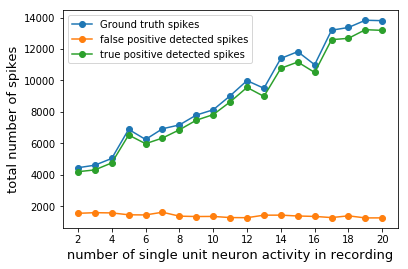

In [288]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

x = np.arange(2, 21)
plt.plot(x, avg_per_single_unit_total, marker='o')

plt.plot(x, avg_per_single_unit_fp, marker='o')

plt.plot(x, avg_per_single_unit_tp, marker='o')

plt.xlabel('xlabel', fontsize=18)
plt.xlabel('number of single unit neuron activity in recording', fontsize=13)
plt.ylabel('total number of spikes', fontsize=13)
ax.legend(labels=["Ground truth spikes","false positive detected spikes", "true positive detected spikes"])

plt.savefig('detections.jpg')


In [252]:
print(np.sum(avg_per_single_unit_tp) /np.sum(avg_per_single_unit_total))


0.9505855934262044


In [289]:
avg_per_multi_tp = np.zeros((95))
avg_per_multi_unit_fp = np.zeros((95))
avg_per_mutli_unit_total = np.zeros((95))
for i in range(50):
    indices = np.where(np.asarray(found_spike_neuron_index_per_rec[i])  > 1)[0];
    avg_per_multi_tp[i] = indices.size
    avg_per_mutli_unit_total[i] = np.where(np.asarray(ground_truth_per_rec[i][1, :]) > 0)[0].size
    avg_per_multi_unit_fp[i] = avg_per_mutli_unit_total[i] - avg_per_multi_tp[i];


In [290]:
np.where(np.asarray(found_spike_neuron_index_per_rec[i])  > 1)[0].size
np.where(np.asarray(ground_truth_per_rec[i]) > 0)[0].size

22195

In [291]:
ground_truth_per_rec[0][1, :]

array([0., 0., 2., ..., 0., 0., 0.])

In [292]:
np.sum(avg_per_multi_tp) / np.sum(avg_per_mutli_unit_total)

0.9708225146327509

In [293]:
features_per_rec

[array([[ 0.05178849, -0.10873772, -0.09056308, ...,  0.0467534 ,
         -0.01730652,  0.05155744],
        [ 0.05909986, -0.04951322, -0.03960485, ...,  0.09757034,
         -0.01202372,  0.00811879],
        [ 0.06341688, -0.11461765,  0.00990002, ...,  0.02672805,
         -0.08387028,  0.04550448],
        ...,
        [ 0.03787225, -0.14045301, -0.00787436, ..., -0.08659759,
         -0.02864958,  0.07281064],
        [ 0.07721826,  0.08903024,  0.08652373, ..., -0.05548157,
         -0.01906618,  0.12323012],
        [-0.04912397, -0.15023413, -0.03638295, ...,  0.03791245,
          0.03752191,  0.11832029]], dtype=float32),
 array([[ 0.04262963, -0.1824605 , -0.09565392, ...,  0.02939094,
          0.08394784,  0.04196363],
        [ 0.0277529 , -0.17793334, -0.0393895 , ..., -0.0491841 ,
          0.01748461,  0.02433207],
        [ 0.05576623,  0.08365845, -0.0072229 , ..., -0.02158539,
          0.17093554,  0.0633629 ],
        ...,
        [ 0.05634727, -0.1263249 , -0.1

In [374]:
feature_list_per_rec = [];
ids_list_per_rec = []


treshold = 0.6;
for k in range(50):
    unit_features = torch.tensor(features_per_rec[k])
    feature_list = torch.unsqueeze(unit_features[0, :], 0).to(device)
    ids_list = torch.tensor([0], dtype=torch.int)
    for i in range(1,unit_features.size()[0]):
        query = torch.unsqueeze(unit_features[i, :], 0).to(device);
        query_raveled = query.view(-1,1);
        score = torch.mm(feature_list, query_raveled);
        max_val, max_ind = torch.max(score, 0);
        # spike is already in list
        if(max_val.item() > treshold):
            ids_list = torch.cat((ids_list, torch.tensor([ids_list[max_ind.item()]], dtype = torch.int)), 0);
        # adds a new spike id
        else:
            new_id = torch.max(ids_list, 0)[0] + 1;
            ids_list = torch.cat((ids_list, torch.tensor([new_id.item()], dtype = torch.int)), 0);

        feature_list = torch.cat((feature_list, query), 0);
    feature_list_per_rec.append(feature_list)
    ids_list_per_rec.append(ids_list)


In [394]:
    unique_classes, nb_of_occourences = np.unique(spike_classes, return_counts=True);
    print(nb_of_occourences)


[1 1 1 1 1]


In [419]:
%pdb on

Automatic pdb calling has been turned ON


In [425]:
for k in range(50):
    found_spike_index = np.asarray(found_spike_neuron_index_per_rec[k]);
    ids_list = ids_list_per_rec[k]
    unique_classes, nb_of_occourences = np.unique(ids_list, return_counts=True);
    spike_classes = np.empty((unique_classes.size,),dtype=object)
    print(np.where(found_spike_index == 0)[0].shape)
    for i in range(spike_classes.size):
        spike_classes[i] = [];

    for i in range(ids_list.nelement()):
        index = found_spike_index[i];
        index_re_id = ids_list[i].item()
        spike_classes[index_re_id].append(index)
    classes_size = np.zeros((spike_classes.size), dtype='int')
    for i in range(spike_classes.size):
        spike_classes[i] = np.asarray(spike_classes[i])
        classes_size[i] = spike_classes[i].size;
        
    for i in range(spike_classes.size):
        unique_classes, nb_of_occourences = np.unique(spike_classes[i], return_counts=True);
        print("max occ: ", np.max(nb_of_occourences), "total: ", np.sum(nb_of_occourences), "id: ", unique_classes[np.argmax(nb_of_occourences)])

        



(1594,)
max occ:  2673 total:  4264 id:  1
max occ:  917 total:  919 id:  3
max occ:  171 total:  171 id:  2
max occ:  243 total:  244 id:  2
max occ:  1 total:  1 id:  2
(1249,)
max occ:  2476 total:  3540 id:  1
max occ:  706 total:  730 id:  7
max occ:  831 total:  832 id:  5
max occ:  175 total:  188 id:  10
max occ:  4 total:  4 id:  4
max occ:  18 total:  26 id:  11
max occ:  794 total:  818 id:  9
max occ:  25 total:  25 id:  2
max occ:  768 total:  797 id:  14
max occ:  634 total:  635 id:  13
max occ:  609 total:  1061 id:  11
max occ:  110 total:  116 id:  10
max occ:  2 total:  2 id:  14
max occ:  376 total:  388 id:  4
max occ:  525 total:  619 id:  15
max occ:  6 total:  6 id:  11
max occ:  58 total:  60 id:  10
max occ:  301 total:  302 id:  12
max occ:  577 total:  608 id:  10
max occ:  174 total:  175 id:  2
max occ:  1 total:  1 id:  2
max occ:  293 total:  294 id:  8
max occ:  215 total:  219 id:  6
max occ:  303 total:  305 id:  3
max occ:  1 total:  1 id:  0
max occ

max occ:  113 total:  113 id:  5
max occ:  501 total:  514 id:  7
max occ:  199 total:  208 id:  3
max occ:  2428 total:  3779 id:  1
max occ:  1045 total:  1050 id:  4
max occ:  142 total:  155 id:  1
max occ:  114 total:  114 id:  5
max occ:  146 total:  149 id:  2
max occ:  728 total:  731 id:  5
max occ:  365 total:  370 id:  2
max occ:  92 total:  93 id:  6
max occ:  1 total:  1 id:  7
max occ:  1 total:  1 id:  3
max occ:  92 total:  96 id:  3
max occ:  2 total:  2 id:  5
max occ:  1 total:  1 id:  5
max occ:  3 total:  5 id:  2
max occ:  1 total:  1 id:  7
max occ:  19 total:  19 id:  2
(2043,)
max occ:  2616 total:  3878 id:  1
max occ:  175 total:  175 id:  8
max occ:  812 total:  844 id:  8
max occ:  722 total:  868 id:  0
max occ:  965 total:  972 id:  6
max occ:  552 total:  555 id:  2
max occ:  140 total:  140 id:  4
max occ:  805 total:  820 id:  4
max occ:  98 total:  99 id:  7
max occ:  168 total:  169 id:  4
max occ:  1 total:  1 id:  1
max occ:  1 total:  1 id:  8
max

max occ:  1135 total:  1499 id:  9
max occ:  77 total:  77 id:  4
max occ:  247 total:  247 id:  13
max occ:  2534 total:  3500 id:  1
max occ:  880 total:  885 id:  7
max occ:  1049 total:  1053 id:  3
max occ:  622 total:  627 id:  5
max occ:  996 total:  1027 id:  15
max occ:  372 total:  375 id:  2
max occ:  994 total:  998 id:  14
max occ:  222 total:  224 id:  2
max occ:  723 total:  834 id:  6
max occ:  96 total:  96 id:  16
max occ:  3 total:  3 id:  10
max occ:  662 total:  683 id:  8
max occ:  406 total:  418 id:  10
max occ:  5 total:  5 id:  8
max occ:  1 total:  1 id:  3
max occ:  3 total:  3 id:  13
max occ:  148 total:  149 id:  12
max occ:  1 total:  1 id:  10
max occ:  1 total:  1 id:  14
max occ:  1 total:  1 id:  10
max occ:  3 total:  3 id:  2
max occ:  1 total:  2 id:  0
max occ:  4 total:  4 id:  10
max occ:  1 total:  1 id:  14
max occ:  1 total:  1 id:  11
max occ:  1 total:  1 id:  10
max occ:  2 total:  2 id:  15
max occ:  1 total:  1 id:  4
max occ:  1 total:

(1124,)
max occ:  867 total:  874 id:  21
max occ:  1 total:  1 id:  12
max occ:  2392 total:  3317 id:  1
max occ:  641 total:  668 id:  9
max occ:  154 total:  154 id:  3
max occ:  500 total:  502 id:  12
max occ:  512 total:  559 id:  19
max occ:  572 total:  576 id:  10
max occ:  315 total:  318 id:  15
max occ:  1100 total:  1113 id:  13
max occ:  1091 total:  1098 id:  18
max occ:  192 total:  213 id:  17
max occ:  211 total:  217 id:  3
max occ:  1026 total:  1057 id:  7
max occ:  859 total:  884 id:  4
max occ:  970 total:  978 id:  8
max occ:  259 total:  267 id:  11
max occ:  560 total:  560 id:  2
max occ:  990 total:  1031 id:  16
max occ:  3 total:  3 id:  20
max occ:  1 total:  1 id:  16
max occ:  1 total:  1 id:  16
max occ:  5 total:  5 id:  12
max occ:  287 total:  288 id:  20
max occ:  5 total:  5 id:  12
max occ:  133 total:  136 id:  5
max occ:  12 total:  12 id:  16
max occ:  95 total:  95 id:  14
max occ:  161 total:  161 id:  15
max occ:  37 total:  37 id:  6
max

max occ:  418 total:  418 id:  3
max occ:  1059 total:  1087 id:  6
max occ:  11 total:  11 id:  9
max occ:  2520 total:  3561 id:  1
max occ:  581 total:  588 id:  5
max occ:  822 total:  846 id:  11
max occ:  4 total:  4 id:  1
max occ:  281 total:  289 id:  5
max occ:  2 total:  2 id:  4
max occ:  233 total:  283 id:  10
max occ:  858 total:  865 id:  7
max occ:  292 total:  292 id:  4
max occ:  634 total:  647 id:  13
max occ:  194 total:  196 id:  13
max occ:  839 total:  843 id:  9
max occ:  803 total:  811 id:  12
max occ:  364 total:  379 id:  8
max occ:  1 total:  1 id:  0
max occ:  25 total:  26 id:  13
max occ:  2 total:  2 id:  11
max occ:  174 total:  174 id:  2
max occ:  1 total:  2 id:  0
max occ:  3 total:  3 id:  11
max occ:  1 total:  1 id:  11
max occ:  1 total:  1 id:  11
max occ:  3 total:  3 id:  11
max occ:  3 total:  3 id:  11
max occ:  1 total:  1 id:  9
max occ:  1 total:  1 id:  5
max occ:  1 total:  1 id:  11
max occ:  1 total:  1 id:  0
(1438,)
max occ:  58

In [373]:
unique_classes

array([1, 2, 3, 4, 5], dtype=int32)

In [272]:
d = feature_list_per_rec;
t = ids_list_per_rec

In [306]:
np.where(np.sort(t[0]) != np.sort(ids_list_per_rec[0]))

(array([5251, 5252, 5253, 5254, 5255, 5256, 5257, 5258, 5259, 5260, 5261,
        5262, 5263, 5264, 5265, 5266, 5267, 5268, 5269, 5270, 5271, 5272,
        5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282, 5283,
        5284, 5285, 5286, 5287, 5288, 5289, 5290, 5291, 5292, 5293, 5294,
        5295, 5296, 5297, 5298, 5299, 5300, 5301, 5302, 5303, 5304, 5305,
        5306, 5307, 5308, 5309, 5310, 5311, 5312, 5313, 5314, 5315, 5316,
        5317, 5318, 5319, 5320, 5321, 5322, 5323, 5324, 5325, 5326, 5327,
        5328, 5329, 5330, 5331, 5332, 5333, 5334, 5335, 5336, 5337, 5338,
        5339, 5340, 5341, 5342, 5343, 5344, 5345, 5346, 5347, 5348, 5349,
        5350, 5351, 5352, 5353, 5590, 5591, 5592, 5593, 5594, 5595, 5596,
        5597, 5598]),)

torch.Size([13202])
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
(17,)


In [363]:
tp_rec = 0;
total_rec = 0;
for k in range(50):
    tp_rec = 0;
    total_rec = 0;
    found_spike_index = np.asarray(found_spike_neuron_index_per_rec[k]);
    ids_list = ids_list_per_rec[k]
    unique_classes, nb_of_occourences = np.unique(ids_list, return_counts=True);
    print(unique_classes)
    print(nb_of_occourences)
    unique_classes, nb_of_occourences = np.unique(found_spike_index, return_counts=True);
    print(unique_classes)
    spike_classes = np.empty((unique_classes.size,),dtype=object)
    for i in range(spike_classes.size):
        spike_classes[i] = [];
    for i in range(found_spike_index.size):
        index = found_spike_index[i];
        index_re_id = ids_list[i]
        if (index == 0):
            spike_classes[index].append(index_re_id.item());
        else:
            spike_classes[index].append(index_re_id.item())
    print('='* 10)
    tp = 0;
    total = 0;
    for i in range(1, spike_classes.size):
        unique_classes, nb_of_occourences = np.unique(spike_classes[i], return_counts=True);
        tp = tp + np.max(nb_of_occourences);
        total = total + np.sum(nb_of_occourences);
        #print("max occ: ", np.max(nb_of_occourences), "total: ", np.sum(nb_of_occourences), "id: ", unique_classes[np.argmax(nb_of_occourences)])
    tp_rec = tp_rec + tp;
    total_rec = total_rec +total;
    print(tp / total)  
    print(total_rec, tp_rec)
print("ddd")
print(tp_rec / total_rec)


[ 1  2  3  4  5  6  7  8  9 10 11 12]
[3254 1008  919  372    1    1   37    2    2    1    1    1]
[0 1 2 3]
0.7660424469413234
4005 3068
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
[3506    1  832   31  298  154    4  816   37  791  442  193 1053   94
    1  226  619    6    3    2   17  315  153   35   19  143  453  151
    7    8  294    3    1    4  516   89  293    1    1    2    2   59
    1    6    2    1   13    7    2    1    1    4    1    5    2    1
    2    1    1    1    1    1    1    1    2    1    1    1    1    4
    1    1    1    1    1    1    2    1    1    1    1    1    1    2
    1    1    1    1    1    1    1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
0.8347123157394198
10515 8777
[ 1  2  3  4  5  6  7  8  9 10 11 12 

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
[ 655  639  805  296  840  856  114    1  760 1902  272   77  382  444
  269 1287   22    3   35  386   27    2    4  424    1   18  238    9
    4   22  368   21   30    2  526   10  684    4   16   10    2  629
   98    1    1    6    8    3    1    2    1    1    1    7    1    2
    2    1    3    3    2   15    1    5    1    1    1    1    1    1
    3    1    1    1    1    1    1    1    1    1    1    1    1    1
    3    1    1    1    1    1    1    1    1    1    1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
0.7416569815706459
12046 8934
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 

0.7662013225569434
6805 5214
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]
[   1   57  300    1 3759  976  344  258  724  656    1  379    5    3
    3    4  494   98    1  421    1   30    6  442   14    5  121  118
    1    1    1    8    2   88    1    3    4    2   10    1    3    1
  170    1    1    4    1    1    2    1    2    2    1    1    1    1
    1    2    1    1    1    1    1    1    1    1    1    1]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
0.8253173828125
8192 6761
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87 

In [332]:
found_spike_index

array([ 0,  6,  1, ...,  9, 14, 10])

[1 2 3 4 5]
[0 1 2 3]
max occ:  2673 total:  2673 id:  1
max occ:  243 total:  415 id:  4
max occ:  917 total:  917 id:  2
0.9570536828963795
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
max occ:  2476 total:  2480 id:  1
max occ:  174 total:  202 id:  20
max occ:  303 total:  307 id:  24
max occ:  376 total:  381 id:  14
max occ:  831 total:  831 id:  3
max occ:  215 total:  235 id:  23
max occ:  706 total:  721 id:  2
max occ:  293 total:  293 id:  22
max occ:  794 total:  794 id:  7
max occ:  577 total:  968 id:  19
max occ:  609 total:  652 id:  11
max occ:  301 total:  303 id:  18
max occ:  634 total:  634 id:  10
max occ:  768 total:  776 id:  9
max occ:  525 total:  525 id:  15
max occ:  387 total:  413 id:  11
0.9480741797432239
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[0 1 2 3 4 5 6 7 8]
max occ:  2624 total:  2624 id:  3
max occ:  160 total:  160 

max occ:  2541 total:  2580 id:  3
max occ:  84 total:  84 id:  2
max occ:  538 total:  588 id:  7
max occ:  671 total:  769 id:  4
max occ:  225 total:  232 id:  19
max occ:  474 total:  474 id:  12
max occ:  577 total:  577 id:  9
max occ:  469 total:  473 id:  13
max occ:  155 total:  155 id:  11
max occ:  413 total:  413 id:  17
max occ:  137 total:  137 id:  20
max occ:  305 total:  305 id:  10
max occ:  75 total:  75 id:  26
max occ:  237 total:  381 id:  6
0.9527819964103272
[ 1  2  3  4  5  6  7  8  9 10 11]
[0 1 2 3 4 5]
max occ:  2613 total:  2750 id:  4
max occ:  609 total:  621 id:  7
max occ:  590 total:  590 id:  6
max occ:  565 total:  565 id:  5
max occ:  64 total:  64 id:  9
0.9675381263616558
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
max occ:  2395 total:  2405 id:  3
max occ:  526 total:  526 id:  9
max occ:  416 total:  417 id:  14
max occ:  1119 total:  1119 id:  12
max o

max occ:  2392 total:  2397 id:  3
max occ:  560 total:  560 id:  18
max occ:  211 total:  369 id:  13
max occ:  859 total:  868 id:  15
max occ:  133 total:  133 id:  26
max occ:  37 total:  64 id:  30
max occ:  1026 total:  1026 id:  14
max occ:  970 total:  985 id:  16
max occ:  641 total:  641 id:  4
max occ:  572 total:  572 id:  8
max occ:  259 total:  259 id:  17
max occ:  500 total:  524 id:  6
max occ:  1100 total:  1100 id:  10
max occ:  95 total:  96 id:  28
max occ:  315 total:  476 id:  9
max occ:  990 total:  1005 id:  19
max occ:  192 total:  195 id:  12
max occ:  1091 total:  1091 id:  11
max occ:  512 total:  512 id:  7
max occ:  287 total:  290 id:  24
max occ:  867 total:  867 id:  1
0.9699928724162509
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
max occ:  2531 total:  2669 id:  6
max occ:  520 total:  783 id:  10
max occ:  512 total:  544 id:  16
max occ:  691 total:  691 id:  1
max occ:  81 t

In [328]:
ids_list_per_rec[1].shape
np.asarray(found_spike_index_per_rec[1]).shape

(13459,)

In [331]:
found_spike_index

array([ 0,  6,  1, ...,  9, 14, 10])